In [108]:
import casadi
import numpy as np
from math import *

In [109]:
# OCDT相关参数及集合
Nfe = 10
K_radau = 3
I = np.arange(1,Nfe+1)
I1 = np.arange(1,Nfe)
J = np.arange(1,K_radau+1)
K = np.arange(0,K_radau+1)
tao = np.array([0.0, 0.1550510257216822, 0.6449489742783178, 1.0])
dljtauk = np.zeros((4,4))
dljtauk[0,:] = [-9.0000, 10.0488, -1.3821, 0.3333]
dljtauk[1,:] = [-4.1394, 3.2247, 1.1678, -0.2532]
dljtauk[2,:] = [1.7394, -3.5678, 0.7753, 1.0532]
dljtauk[3,:] = [-3, 5.5320, -7.5320, 5.0000]
dljtauk = dljtauk.transpose()
print(dljtauk)

[[-9.     -4.1394  1.7394 -3.    ]
 [10.0488  3.2247 -3.5678  5.532 ]
 [-1.3821  1.1678  0.7753 -7.532 ]
 [ 0.3333 -0.2532  1.0532  5.    ]]


In [110]:
#车辆自身参数
L_wheelbase = 2.8
a_max = 0.3
v_max = 2.0
phy_max = 0.72
w_max = 0.54

In [111]:
#决策变量
x = casadi.SX.sym('x', 11, 4)
y = casadi.SX.sym('y', 11, 4)
theta = casadi.SX.sym('theta', 11, 4)
v = casadi.SX.sym('v', 11, 4)
phy = casadi.SX.sym('phy', 11, 4)

a = casadi.SX.sym('a', 11, 4)
w = casadi.SX.sym('w', 11, 4)
tf = casadi.SX.sym('tf')
hi = casadi.SX.sym('hi')


X = casadi.transpose(x[1:,:])
X = casadi.reshape(X,-1,1)

Y = casadi.transpose(y[1:,:])
Y = casadi.reshape(Y,-1,1)

THETA = casadi.transpose(theta[1:,:])
THETA = casadi.reshape(THETA,-1,1)

V = casadi.transpose(v[1:,:])
V = casadi.reshape(V,-1,1)

PHY = casadi.transpose(phy[1:,:])
PHY = casadi.reshape(PHY,-1,1)

A = casadi.transpose(a[1:,1:])
A = casadi.reshape(A,-1,1)

W = casadi.transpose(w[1:,1:])
W = casadi.reshape(W,-1,1)

In [112]:
#等式约束
g = []
gl = []
gu = []
for i in I:
    for k in J:
        temp_gx     = dljtauk[0,k]*x[i,0]     + dljtauk[1,k]*x[i,1]     + dljtauk[2,k]*x[i,2]     + dljtauk[3,k]*x[i,3]\
                     - hi*v[i,k]*casadi.cos(theta[i,k])
        temp_gy     = dljtauk[0,k]*y[i,0]     + dljtauk[1,k]*y[i,1]     + dljtauk[2,k]*y[i,2]     + dljtauk[3,k]*y[i,3]\
                     - hi*v[i,k]*casadi.sin(theta[i,k])
        temp_gtheta = dljtauk[0,k]*theta[i,0] + dljtauk[1,k]*theta[i,1] + dljtauk[2,k]*theta[i,2] + dljtauk[3,k]*theta[i,3]\
                     - hi*casadi.tan(phy[i,k])*v[i,k]/L_wheelbase
        temp_gv     = dljtauk[0,k]*v[i,0]     + dljtauk[1,k]*v[i,1]     + dljtauk[2,k]*v[i,2]     + dljtauk[3,k]*v[i,3]\
                     - hi*a[i,k]
        temp_gphy   = dljtauk[0,k]*phy[i,0]   + dljtauk[1,k]*phy[i,1]   + dljtauk[2,k]*phy[i,2]   + dljtauk[3,k]*phy[i,3]\
                       - hi*w[i,k]
        g.append(temp_gx)
        gl.append(0.0)
        gu.append(0.0)
        g.append(temp_gy)
        gl.append(0.0)
        gu.append(0.0)
        g.append(temp_gtheta)
        gl.append(0.0)
        gu.append(0.0)
        g.append(temp_gv)
        gl.append(0.0)
        gu.append(0.0)
        g.append(temp_gphy)
        gl.append(0.0)
        gu.append(0.0)


for i in I1:
    temp_eqx = 0
    temp_eqy = 0
    temp_eqtheta = 0
    temp_eqv = 0
    temp_eqphy = 0
    for j in K:
        temp_eqx_ = 1
        temp_eqy_ = 1
        temp_eqtheta_ = 1
        temp_eqv_ = 1
        temp_eqphy_ = 1
        for k in K:
            if j != k:
                temp_eqx_ *= (1-tao[k])/(tao[j]-tao[k])
                temp_eqy_ *= (1-tao[k])/(tao[j]-tao[k])
                temp_eqtheta_ *= (1-tao[k])/(tao[j]-tao[k])
                temp_eqv_ *= (1-tao[k])/(tao[j]-tao[k])
                temp_eqphy_ *= (1-tao[k])/(tao[j]-tao[k])
        temp_eqx += temp_eqx_ * x[i,j]
        temp_eqy += temp_eqy_ * y[i,j]
        temp_eqtheta += temp_eqtheta_ * theta[i,j]
        temp_eqv += temp_eqv_ * v[i,j]
        temp_eqphy += temp_eqphy_ * phy[i,j]

    g.append(x[i+1,0]-temp_eqx)
    gl.append(0.0)
    gu.append(0.0)
    g.append(y[i+1,0]-temp_eqy)
    gl.append(0.0)
    gu.append(0.0)
    g.append(theta[i+1,0]-temp_eqtheta)
    gl.append(0.0)
    gu.append(0.0)
    g.append(v[i+1,0]-temp_eqv)
    gl.append(0.0)
    gu.append(0.0)
    g.append(phy[i+1,0]-temp_eqphy)
    gl.append(0.0)
    gu.append(0.0)


In [113]:
#不等式约束
for i in I:
    for j in K:
        g.append(v[i,j])
        gl.append(-v_max)
        gu.append(v_max)

        g.append(phy[i,j])
        gl.append(-phy_max)
        gu.append(phy_max)
    
for i in I:
    for j in J:
        g.append(a[i,j])
        gl.append(-a_max)
        gu.append(a_max)

        g.append(w[i,j])
        gl.append(-w_max)
        gu.append(w_max)

g.append(x[1,0])
gl.append(1.03)
gu.append(1.03)

g.append(y[1,0])
gl.append(2.41)
gu.append(2.41)

g.append(theta[1,0])
gl.append(-0.03)
gu.append(-0.03)

g.append(v[1,0])
gl.append(0.1)
gu.append(0.1)

g.append(phy[1,0])
gl.append(-0.08)
gu.append(-0.08)

g.append(x[Nfe,K_radau])
gl.append(5.31)
gu.append(5.31)

g.append(y[Nfe,K_radau])
gl.append(2.41)
gu.append(2.41)

g.append(theta[Nfe,K_radau])
gl.append(-3.1416)
gu.append(-3.1416)

g.append(v[Nfe,K_radau])
gl.append(0.0)
gu.append(0.0)

g.append(phy[Nfe,K_radau])
gl.append(0.0)
gu.append(0.0)

g.append(a[Nfe,K_radau])
gl.append(0.0)
gu.append(0.0)

g.append(w[Nfe,K_radau])
gl.append(0.0)
gu.append(0.0)

g.append(tf)
gl.append(0.0)
gu.append(inf)

g.append(hi-tf/Nfe)
gl.append(0.0)
gu.append(0.0)


In [114]:
#目标函数
F = 0
for i in I:
    for j in J:
        F += w[i,j]*w[i,j]
F = F + 10*tf

In [115]:
nlp = {'x':casadi.vertcat(X,Y,THETA,V,PHY,A,W,tf,hi), 'f':F, 'g':casadi.vertcat(*g)}
# nlp = {'x':casadi.vertcat(X,Y,THETA,V,PHY,A,W,tf,hi), 'f':F, 'g':casadi.vertcat(*g)}
# print(nlp)

print(casadi.vertcat(X,Y,THETA,V,PHY,A,W,tf,hi))

[x_1, x_12, x_23, x_34, x_2, x_13, x_24, x_35, x_3, x_14, x_25, x_36, x_4, x_15, x_26, x_37, x_5, x_16, x_27, x_38, x_6, x_17, x_28, x_39, x_7, x_18, x_29, x_40, x_8, x_19, x_30, x_41, x_9, x_20, x_31, x_42, x_10, x_21, x_32, x_43, y_1, y_12, y_23, y_34, y_2, y_13, y_24, y_35, y_3, y_14, y_25, y_36, y_4, y_15, y_26, y_37, y_5, y_16, y_27, y_38, y_6, y_17, y_28, y_39, y_7, y_18, y_29, y_40, y_8, y_19, y_30, y_41, y_9, y_20, y_31, y_42, y_10, y_21, y_32, y_43, theta_1, theta_12, theta_23, theta_34, theta_2, theta_13, theta_24, theta_35, theta_3, theta_14, theta_25, theta_36, theta_4, theta_15, theta_26, theta_37, theta_5, theta_16, theta_27, theta_38, theta_6, theta_17, theta_28, theta_39, theta_7, theta_18, theta_29, theta_40, theta_8, theta_19, theta_30, theta_41, theta_9, theta_20, theta_31, theta_42, theta_10, theta_21, theta_32, theta_43, v_1, v_12, v_23, v_34, v_2, v_13, v_24, v_35, v_3, v_14, v_25, v_36, v_4, v_15, v_26, v_37, v_5, v_16, v_27, v_38, v_6, v_17, v_28, v_39, v_7, v_1

In [116]:
S = casadi.nlpsol('S', 'ipopt', nlp)
print(S)

S:(x0[262],p[],lbx[262],ubx[262],lbg[349],ubg[349],lam_x0[262],lam_g0[349])->(x[262],f,g[349],lam_x[262],lam_g[349],lam_p[]) IpoptInterface


In [117]:
#初解
x = np.zeros((11,4))
y = np.zeros((11,4))
theta = np.zeros((11,4))
v = np.zeros((11,4))
phy = np.zeros((11,4))
a = np.zeros((11,4))
w = np.zeros((11,4))


x[1,0]=1.030
y[1,0]=2.410
theta[1,0]=-0.030
v[1,0]=0.100
phy[1,0]=-0.080
x[1,1]=1.047
y[1,1]=2.411
theta[1,1]=-0.026
v[1,1]=0.005
phy[1,1]=0.045
x[1,2]=0.903
y[1,2]=2.415
theta[1,2]=-0.068
v[1,2]=-0.293
phy[1,2]=0.689
x[1,3]=0.615
y[1,3]=2.448
theta[1,3]=-0.156
v[1,3]=-0.510
phy[1,3]=0.720
a[1,1]=-0.300
w[1,1]=0.540
a[1,2]=-0.300
w[1,2]=0.488
a[1,3]=-0.300
w[1,3]=-0.540
x[2,0]=0.615
y[2,0]=2.448
theta[2,0]=-0.156
v[2,0]=-0.510
phy[2,0]=0.720
x[2,1]=0.449
y[2,1]=2.480
theta[2,1]=-0.213
v[2,1]=-0.519
phy[2,1]=0.720
x[2,2]=0.033
y[2,2]=2.595
theta[2,2]=-0.321
v[2,2]=-0.324
phy[2,2]=0.477
x[2,3]=-0.115
y[2,3]=2.647
theta[2,3]=-0.344
v[2,3]=-0.098
phy[2,3]=0.134
a[2,1]=0.041
w[2,1]=-0.067
a[2,2]=0.300
w[2,2]=-0.396
a[2,3]=0.300
w[2,3]=-0.540
x[3,0]=-0.115
y[3,0]=2.647
theta[3,0]=-0.344
v[3,0]=-0.098
phy[3,0]=0.134
x[3,1]=-0.130
y[3,1]=2.651
theta[3,1]=-0.341
v[3,1]=-0.004
phy[3,1]=0.016
x[3,2]=0.007
y[3,2]=2.602
theta[3,2]=-0.379
v[3,2]=0.295
phy[3,2]=-0.665
x[3,3]=0.272
y[3,3]=2.482
theta[3,3]=-0.466
v[3,3]=0.512
phy[3,3]=-0.720
a[3,1]=0.300
w[3,1]=-0.540
a[3,2]=0.300
w[3,2]=-0.540
a[3,3]=0.300
w[3,3]=0.540
x[4,0]=0.272
y[4,0]=2.482
theta[4,0]=-0.466
v[4,0]=0.512
phy[4,0]=-0.720
x[4,1]=0.424
y[4,1]=2.399
theta[4,1]=-0.521
v[4,1]=0.606
phy[4,1]=-0.720
x[4,2]=1.032
y[4,2]=1.949
theta[4,2]=-0.757
v[4,2]=0.905
phy[4,2]=-0.720
x[4,3]=1.499
y[4,3]=1.391
theta[4,3]=-0.986
v[4,3]=1.122
phy[4,3]=-0.720
a[4,1]=0.300
w[4,1]=0.000
a[4,2]=0.300
w[4,2]=-0.000
a[4,3]=0.300
w[4,3]=0.000
x[5,0]=1.499
y[5,0]=1.391
theta[5,0]=-0.986
v[5,0]=1.122
phy[5,0]=-0.720
x[5,1]=1.672
y[5,1]=1.094
theta[5,1]=-1.093
v[5,1]=1.038
phy[5,1]=-0.720
x[5,2]=1.967
y[5,2]=0.260
theta[5,2]=-1.373
v[5,2]=0.750
phy[5,2]=-0.720
x[5,3]=2.025
y[5,3]=-0.200
theta[5,3]=-1.518
v[5,3]=0.532
phy[5,3]=-0.720
a[5,1]=-0.273
w[5,1]=0.000
a[5,2]=-0.300
w[5,2]=-0.000
a[5,3]=-0.300
w[5,3]=0.000
x[6,0]=2.025
y[6,0]=-0.200
theta[6,0]=-1.518
v[6,0]=0.532
phy[6,0]=-0.720
x[6,1]=2.026
y[6,1]=-0.353
theta[6,1]=-1.570
v[6,1]=0.438
phy[6,1]=-0.720
x[6,2]=2.019
y[6,2]=-0.640
theta[6,2]=-1.638
v[6,2]=0.139
phy[6,2]=-0.337
x[6,3]=2.016
y[6,3]=-0.662
theta[6,3]=-1.641
v[6,3]=-0.078
phy[6,3]=0.041
a[6,1]=-0.300
w[6,1]=0.125
a[6,2]=-0.300
w[6,2]=0.540
a[6,3]=-0.300
w[6,3]=0.452
x[7,0]=2.016
y[7,0]=-0.662
theta[7,0]=-1.641
v[7,0]=-0.078
phy[7,0]=0.041
x[7,1]=2.021
y[7,1]=-0.623
theta[7,1]=-1.636
v[7,1]=-0.172
phy[7,1]=0.189
x[7,2]=2.051
y[7,2]=-0.303
theta[7,2]=-1.720
v[7,2]=-0.471
phy[7,2]=0.720
x[7,3]=2.141
y[7,3]=0.105
theta[7,3]=-1.852
v[7,3]=-0.688
phy[7,3]=0.720
a[7,1]=-0.300
w[7,1]=0.540
a[7,2]=-0.300
w[7,2]=0.351
a[7,3]=-0.300
w[7,3]=-0.444
x[8,0]=2.141
y[8,0]=0.105
theta[8,0]=-1.852
v[8,0]=-0.688
phy[8,0]=0.720
x[8,1]=2.197
y[8,1]=0.303
theta[8,1]=-1.917
v[8,1]=-0.755
phy[8,1]=0.720
x[8,2]=2.675
y[8,2]=1.147
theta[8,2]=-2.221
v[8,2]=-1.126
phy[8,2]=0.720
x[8,3]=3.254
y[8,3]=1.742
theta[8,3]=-2.483
v[8,3]=-1.152
phy[8,3]=0.720
a[8,1]=-0.300
w[8,1]=-0.000
a[8,2]=-0.290
w[8,2]=0.000
a[8,3]=0.300
w[8,3]=-0.000
x[9,0]=3.254
y[9,0]=1.742
theta[9,0]=-2.483
v[9,0]=-1.152
phy[9,0]=0.720
x[9,1]=3.543
y[9,1]=1.939
theta[9,1]=-2.592
v[9,1]=-1.058
phy[9,1]=0.720
x[9,2]=4.366
y[9,2]=2.298
theta[9,2]=-2.875
v[9,2]=-0.759
phy[9,2]=0.720
x[9,3]=4.828
y[9,3]=2.387
theta[9,3]=-3.022
v[9,3]=-0.542
phy[9,3]=0.720
a[9,1]=0.300
w[9,1]=-0.000
a[9,2]=0.300
w[9,2]=0.000
a[9,3]=0.300
w[9,3]=-0.000
x[10,0]=4.828
y[10,0]=2.387
theta[10,0]=-3.022
v[10,0]=-0.542
phy[10,0]=0.720
x[10,1]=4.997
y[10,1]=2.399
theta[10,1]=-3.078
v[10,1]=-0.462
phy[10,1]=0.710
x[10,2]=5.272
y[10,2]=2.411
theta[10,2]=-3.142
v[10,2]=-0.123
phy[10,2]=0.235
x[10,3]=5.310
y[10,3]=2.410
theta[10,3]=-3.142
v[10,3]=0.000
phy[10,3]=0.000
a[10,1]=0.300
w[10,1]=-0.205
a[10,2]=0.300
w[10,2]=-0.540
a[10,3]=0.000
w[10,3]=0.000

init_tf = np.array([45])
init_hi = np.array([4.5])

np.savez("init_planning.npz", x = x, y = y, theta = theta, v = v, phy = phy, a = a, w = w, tf = init_tf, hi = init_hi) # 多个数组存入一个.npz压缩包
init_x = x[1:,:].reshape(-1).tolist()
init_y = y[1:,:].reshape(-1).tolist()
init_theta = theta[1:,:].reshape(-1).tolist()
init_v = v[1:,:].reshape(-1).tolist()
init_phy = phy[1:,:].reshape(-1).tolist()
init_a = a[1:,1:].reshape(-1).tolist()
init_w = w[1:,1:].reshape(-1).tolist()
init_tf = init_tf.tolist()
init_hi = init_hi.tolist()

init = init_x+init_y+init_theta+init_v+init_phy+init_a+init_w+init_tf+init_hi

len(init)

262

In [118]:
# r = S(x0=[init_x,init_y,init_theta,init_v,init_phy,init_a,init_w,init_tf,init_hi],lbg = gl, ubg=gu)
# r = S(x0=init,lbg = gl, ubg=gu)
r = S(x0=init, lbg = gl, ubg=gu)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1094
Number of nonzeros in inequality constraint Jacobian.:      141
Number of nonzeros in Lagrangian Hessian.............:      300

Total number of variables............................:      262
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      208
Total number of inequality constraints...............:      141
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:      140
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

In [119]:
res = r['x']
X_star = res[0:40]
Y_star = res[40:80]
THETA_star = res[80:120]
V_star = res[120:160]
PHY_star = res[160:200]
A_star = res[200:230]
W_star = res[230:260]
TF_star = res[260:261]
HI_star = res[261:262]

print(X_star[-2:-1])
print(Y_star[-2:-1])
print(THETA_star[-2:-1])
print(V_star[-2:-1])
print(PHY_star[-2:-1])
print(A_star[-2:-1])
print(W_star[-2:-1])

5.27168
2.41117
-3.14215
-0.123471
0.234503
0.3
-0.54


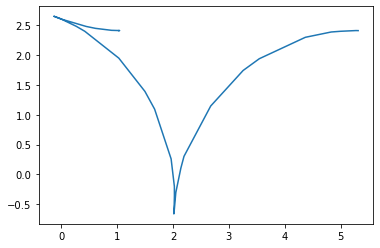

In [120]:
X_star=X_star.elements()
Y_star=Y_star.elements()

import matplotlib.pyplot as plt

plt.plot(init_x,init_y)



# X_star = casadi.transpose()

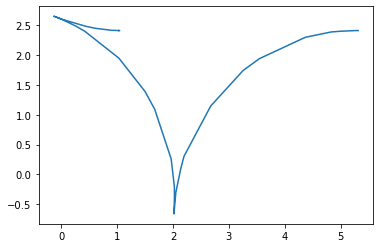

In [121]:
plt.plot(X_star,Y_star)